# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [2]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True) 


# Check if any GPU is detected
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. The code will run on CPU.")

No GPU detected. The code will run on CPU.


# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

<span style="color:blue">The Nvidia RTX 3090 graphics card has 10,496 CUDA cores1</span>
 
<span style="color:blue">reference: https://www.nvidia.com/sv-se/geforce/graphics-cards/30-series/rtx-3090-3090ti/</span>

Question 2: How much memory does the graphics card have?

<span style="color:blue">The Nvidia RTX 3090 graphics card has 24 GB of GDDR6X memory</span>

Question 3: What is stored in the GPU memory while training a DNN ?

<span style="color:blue">1) Model Parameters: These include the weights and biases for each layer in the network.</span>

<span style="color:blue">2) Intermediate Computations: The outputs of each layer in the network are stored for backpropagation.</span>

<span style="color:blue">3) Optimizer States: If the optimizer maintains a state (like in Adam or RMSprop), these are also stored in the GPU memory.</span>

<span style="color:blue">4) Mini-batch Data: The input data for the current mini-batch is loaded into GPU memory.</span>

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [3]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class    
unique, counts = np.unique(Y, return_counts=True)
for unique_classe, count in zip(unique, counts):
    print(f"Class {int(unique_classe)}: {count} examples")

The covariates have size (764137, 92).
The labels have size (764137,).
Class 0: 121621 examples
Class 1: 642516 examples


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [4]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
most_common_class_count = max(counts)
total_examples = sum(counts)
naive_classifier_accuracy = most_common_class_count / total_examples
print(f"A naive classifier, which always predicts the most common class, would have an accuracy of {naive_classifier_accuracy}.")

# Print the number of NaNs (not a number) in the labels
nan_in_labels = np.isnan(Y).sum()
nan_in_covariates = np.isnan(X).sum()


# Print the number of NaNs in the covariates
print(f"The labels have {nan_in_labels} NaNs.")
print(f"The covariates have {nan_in_covariates} NaNs.")



A naive classifier, which always predicts the most common class, would have an accuracy of 0.8408387501194158.
The labels have 0 NaNs.
The covariates have 0 NaNs.


# Part 6: Preprocessing

Lets do some simple preprocessing

In [5]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
X = X - np.mean(X, axis=0)


# Divide each covariate (column) by its standard deviation
X = X / np.std(X, axis=0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print('Mean:', np.mean(X, axis=0))
print('Standard deviation:', np.std(X, axis=0))


Mean: [-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  2

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [6]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state=42)


print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
unique_train, counts_train = np.unique(Ytrain, return_counts=True)
print("\nNumber of examples of each class in the training data: ")
for unique_train_class, count_train in zip(unique_train, counts_train):
    print(f"Class {int(unique_train_class)}: {count_train} examples")

    
unique_temp, counts_temp = np.unique(Ytemp, return_counts=True)
print("\nNumber of examples of each class in the remaining 30% data: ")
for unique_temp_class, count_temp in zip(unique_temp, counts_temp):
    print(f"Class {int(unique_temp_class)}: {count_temp} examples")


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).

Number of examples of each class in the training data: 
Class 0: 85248 examples
Class 1: 449647 examples

Number of examples of each class in the remaining 30% data: 
Class 0: 36373 examples
Class 1: 192869 examples


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [7]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=42)

unique_val, counts_val = np.unique(Yval, return_counts=True)
print("Number of examples of each class in the validation data: ", dict(zip(unique_val, counts_val)))

unique_test, counts_test = np.unique(Ytest, return_counts=True)
print("Number of examples of each class in the test data: ", dict(zip(unique_test, counts_test)))

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

Number of examples of each class in the validation data:  {0: 18291, 1: 96330}
Number of examples of each class in the test data:  {0: 18082, 1: 96539}
The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).

<span style="color:blue"> Sigmoid activation function is for outputing the probability. One is because this is a binary classification task.</span>


In [37]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout 
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False, dropout_rate = 0.5):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
        
    # Setup a sequential model
    model = Sequential()

    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization(momentum=0.75))
        if use_dropout:
            model.add(Dropout(dropout_rate))
        if use_custom_dropout:
            model.add(myDropout(dropout_rate))  # Add custom dropout after each Dense layer
    
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))  
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [9]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [10]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (Xtrain.shape[1],)

# Build the model
model1 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 =  model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval))

Epoch 1/20
54/54 [==============================] - 2s 20ms/step - loss: 0.3094 - accuracy: 0.8457 - val_loss: 0.1895 - val_accuracy: 0.9003
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1833 - accuracy: 0.9006 - val_loss: 0.1762 - val_accuracy: 0.9036
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1744 - accuracy: 0.9059 - val_loss: 0.1697 - val_accuracy: 0.9098
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1694 - accuracy: 0.9090 - val_loss: 0.1657 - val_accuracy: 0.9113
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1664 - accuracy: 0.9102 - val_loss: 0.1632 - val_accuracy: 0.9144
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9144 - val_loss: 0.1614 - val_accuracy: 0.9167
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1627 - accuracy: 0.9147 - val_loss: 0.1599 - val_accuracy: 0.9170
Epoch 8/20
54/54 [=

In [11]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1492
Test accuracy: 0.9192


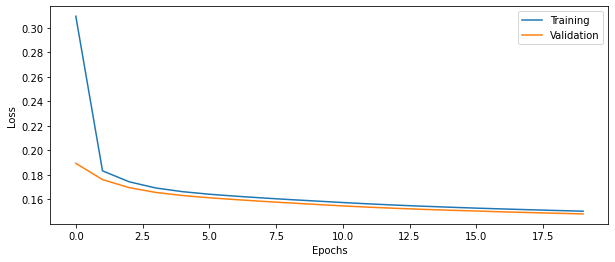

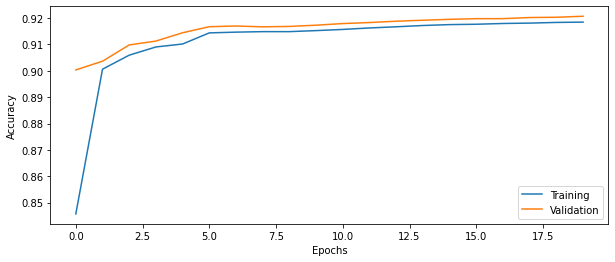

In [12]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

<span style="color:blue">If adding several Dense layers in Keras without specifying an activation function, the layers will have a linear activation function by default in Keras. This means that they will not apply any activation function to their input, they will just pass it on. If stacking several of these layers together, they will still behave as a single layer, because the composition of linear functions is still a linear function. This is why it’s important to add a non-linear activation function between the Dense layers: it allows the stack of layers to model more complex patterns.</span>


Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

<span style="color:blue">In Keras, the weights in each Dense layer are initialized using ‘Glorot Uniform’ initializer, also known as the Xavier uniform initializer. It draws samples from a uniform distribution within [-limit, limit], where limit is sqrt(6 / (fan_in + fan_out)) and fan_in is the number of input units in the weight tensor and fan_out is the number of output units. The bias weights in each Dense layer are initialized with zeros by default. This is a common and safe practice because the bias terms are independent of the input data, and setting them to zero doesn’t prevent the model from learning appropriate bias values during training.</span>


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [13]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(Ytrain), Ytrain)


# Print the class weights
print("Class weights: ", class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {i : class_weights[i] for i in range(len(class_weights))}

print("Class weights in Keras format: ", class_weights)

Class weights:  [3.13728768 0.59479436]
Class weights in Keras format:  {0: 3.1372876783033035, 1: 0.5947943609097803}


### 2 layers, 20 nodes, class weights

In [14]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],) 

# Build and train model
model2 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 21ms/step - loss: 0.3277 - accuracy: 0.8748 - val_loss: 0.2469 - val_accuracy: 0.8898
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1956 - accuracy: 0.8952 - val_loss: 0.2327 - val_accuracy: 0.9011
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1851 - accuracy: 0.9019 - val_loss: 0.2279 - val_accuracy: 0.9064
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1794 - accuracy: 0.9081 - val_loss: 0.2186 - val_accuracy: 0.9115
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1758 - accuracy: 0.9103 - val_loss: 0.2176 - val_accuracy: 0.9126
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1733 - accuracy: 0.9110 - val_loss: 0.2153 - val_accuracy: 0.9131
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1714 - accuracy: 0.9123 - val_loss: 0.2133 - val_accuracy: 0.9150
Epoch 8/20
54/54 

In [15]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2056
Test accuracy: 0.9168


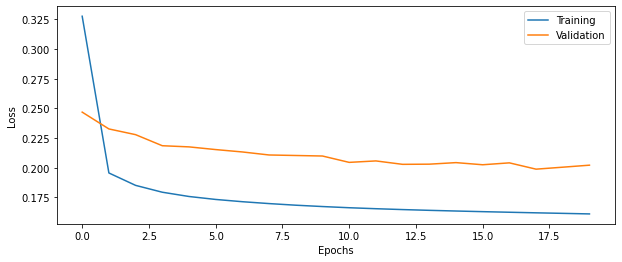

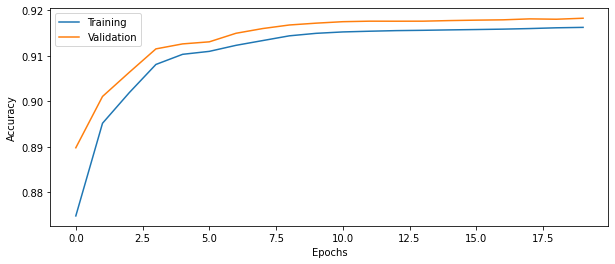

In [16]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

<span style="color:blue">We use a batch size because it’s not feasible to fit all data into memory at once, especially for large datasets. Also, using smaller batches makes the network update weights more frequently, leading to a faster convergence, and introduces some noise into the learning process, helping the model avoid local minima.</span>

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

<span style="color:blue">The weights in the DNN are updated after each batch is processed. So, in this case our training set has 534895 samples, the weights get updated 5349 times (534895 / 100), 535 times (534895 / 1000) and 54 times (534895 / 10000) when the batch size is 100, 1000 and 10000, respectively.</span>

Question 11: What limits how large the batch size can be?

<span style="color:blue">The maximum batch size is limited by the memory capacity of the hardware. If trying to use a batch size that is too large, it will run out of memory.</span>

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

<span style="color:blue">If the batch size is decreased, the learning rate should also be decreased. This is because with a smaller batch size, the gradient estimate will have higher variance, and a high learning rate can amplify this variance, leading to unstable training.</span>

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

<span style="color:blue">  number_of_nodes. The “+1” is due to the bias terms, one for each node. For a network with 2 layers and 20 nodes per layer, assuming the input has n features:</span>

<span style="color:blue"> The first layer has (n + 1) * 20 parameters.</span>
<span style="color:blue"> The second layer has (20 + 1) * 20 parameters (since the input to this layer is the output of the first layer, which has 20 nodes).</span>

<span style="color:blue"> For a network with 4 layers and 50 nodes per layer:</span>

<span style="color:blue"> The first layer has (n + 1) * 50 parameters.</span>
<span style="color:blue"> Each of the next three layers has (50 + 1) * 50 parameters.</span>

In [32]:
model5.summary(), model2.summary()
print('There are 12351 and 2301 trainable parameters in these two models.')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                4650      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12351 (48.25 KB)
Trainable params: 12351 (48.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

### 4 layers, 20 nodes, class weights

In [17]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model3 = build_DNN(input_shape, n_layers=4, n_nodes=20, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 21ms/step - loss: 0.6898 - accuracy: 0.6581 - val_loss: 0.6828 - val_accuracy: 0.8976
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6426 - accuracy: 0.8869 - val_loss: 0.4941 - val_accuracy: 0.8859
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2612 - accuracy: 0.8860 - val_loss: 0.2435 - val_accuracy: 0.8974
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1910 - accuracy: 0.8990 - val_loss: 0.2310 - val_accuracy: 0.9038
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1820 - accuracy: 0.9057 - val_loss: 0.2233 - val_accuracy: 0.9098
Epoch 6/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1771 - accuracy: 0.9102 - val_loss: 0.2183 - val_accuracy: 0.9142
Epoch 7/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1740 - accuracy: 0.9127 - val_loss: 0.2164 - val_accuracy: 0.9156
Epoch 8/20
54/54 [

In [18]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2059
Test accuracy: 0.9181


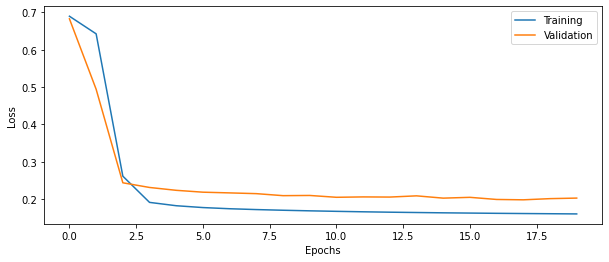

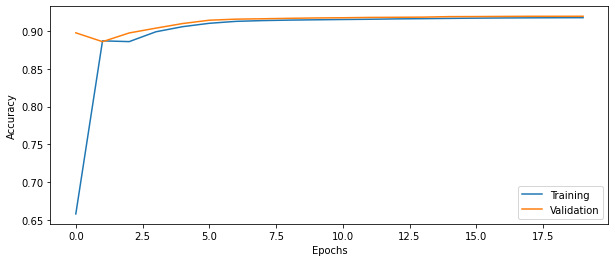

In [19]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [20]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model4 = build_DNN(input_shape, n_layers=2, n_nodes=50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 15ms/step - loss: 0.3471 - accuracy: 0.8433 - val_loss: 0.2500 - val_accuracy: 0.8943
Epoch 2/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1931 - accuracy: 0.8967 - val_loss: 0.2291 - val_accuracy: 0.9016
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1837 - accuracy: 0.9029 - val_loss: 0.2224 - val_accuracy: 0.9082
Epoch 4/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1788 - accuracy: 0.9086 - val_loss: 0.2199 - val_accuracy: 0.9114
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1756 - accuracy: 0.9102 - val_loss: 0.2175 - val_accuracy: 0.9123
Epoch 6/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1734 - accuracy: 0.9108 - val_loss: 0.2167 - val_accuracy: 0.9131
Epoch 7/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1718 - accuracy: 0.9124 - val_loss: 0.2174 - val_accuracy: 0.9145
Epoch 8/20
54

In [21]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2081
Test accuracy: 0.9168


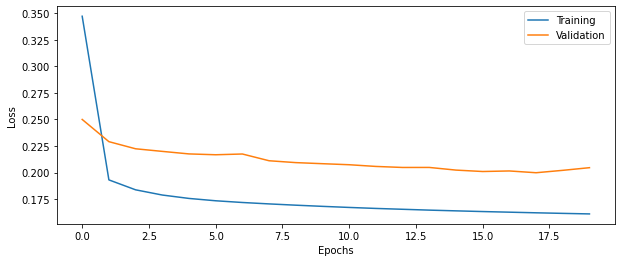

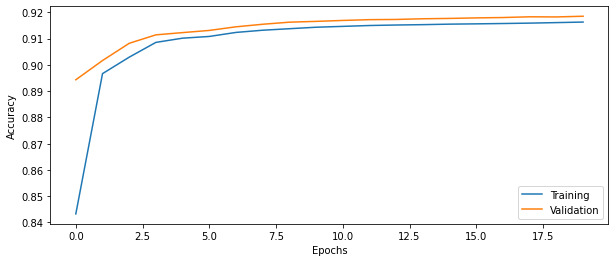

In [22]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [23]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model5 = build_DNN(input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 22ms/step - loss: 0.6890 - accuracy: 0.6607 - val_loss: 0.6851 - val_accuracy: 0.8791
Epoch 2/20
54/54 [==============================] - 1s 16ms/step - loss: 0.5590 - accuracy: 0.8663 - val_loss: 0.2812 - val_accuracy: 0.8820
Epoch 3/20
54/54 [==============================] - 1s 17ms/step - loss: 0.2082 - accuracy: 0.8877 - val_loss: 0.2414 - val_accuracy: 0.8980
Epoch 4/20
54/54 [==============================] - 1s 17ms/step - loss: 0.1907 - accuracy: 0.8980 - val_loss: 0.2323 - val_accuracy: 0.9024
Epoch 5/20
54/54 [==============================] - 1s 17ms/step - loss: 0.1819 - accuracy: 0.9059 - val_loss: 0.2245 - val_accuracy: 0.9109
Epoch 6/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1769 - accuracy: 0.9101 - val_loss: 0.2204 - val_accuracy: 0.9126
Epoch 7/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1738 - accuracy: 0.9112 - val_loss: 0.2178 - val_accuracy: 0.9139
Epoch 8/20
54

In [24]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1916
Test accuracy: 0.9183


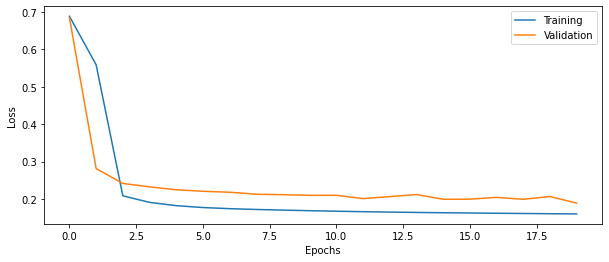

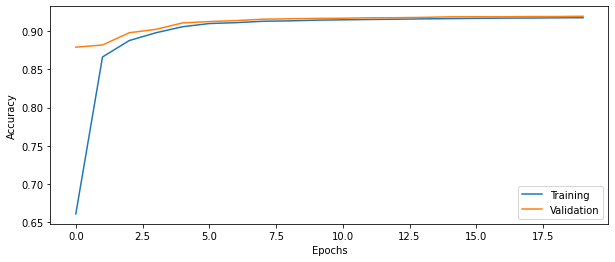

In [25]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

<span style="color:blue">1) Internal Covariate Shift: It helps to mitigate the problem of internal covariate shift, where the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change.</span>

<span style="color:blue">2) Faster Convergence: The network tends to converge faster as batch normalization helps in bringing the inputs to a layer within a similar range.</span>

<span style="color:blue">3) Regularization: It adds a small amount of noise to network. In some cases, such as Inception modules, batch normalization has been found to work as a regularizer, reducing the need for other regularization techniques like dropout.</span>

<span style="color:blue">4) Allows Higher Learning Rates: Gradient descent usually requires small learning rates for the network to converge. As batch normalization regulates the values going into each activation function, higher learning rates can be used without the risk of divergence.</span>

### 2 layers, 20 nodes, class weights, batch normalization

In [26]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model6 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_bn=True)

history6 = model6.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 17ms/step - loss: 0.2295 - accuracy: 0.8941 - val_loss: 0.2230 - val_accuracy: 0.9109
Epoch 2/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1742 - accuracy: 0.9114 - val_loss: 0.2012 - val_accuracy: 0.9159
Epoch 3/20
54/54 [==============================] - 1s 9ms/step - loss: 0.1680 - accuracy: 0.9144 - val_loss: 0.1992 - val_accuracy: 0.9178
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1648 - accuracy: 0.9164 - val_loss: 0.1936 - val_accuracy: 0.9188
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1626 - accuracy: 0.9172 - val_loss: 0.1882 - val_accuracy: 0.9193
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1609 - accuracy: 0.9175 - val_loss: 0.2214 - val_accuracy: 0.9193
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1596 - accuracy: 0.9178 - val_loss: 0.1924 - val_accuracy: 0.9196
Epoch 8/20
54/54 [

In [27]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2168
Test accuracy: 0.9202


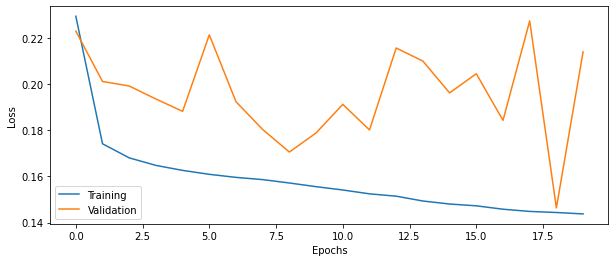

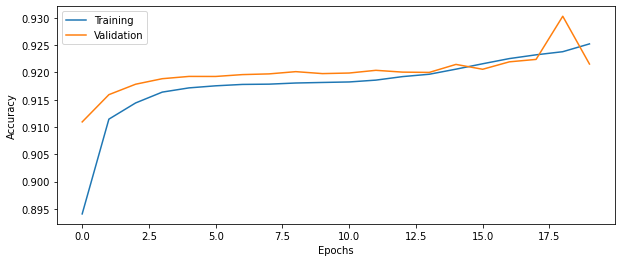

In [28]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [29]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model7 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, act_fun='relu')

history7 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 13ms/step - loss: 0.2311 - accuracy: 0.8853 - val_loss: 0.2333 - val_accuracy: 0.9083
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1745 - accuracy: 0.9103 - val_loss: 0.2113 - val_accuracy: 0.9159
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1667 - accuracy: 0.9147 - val_loss: 0.2074 - val_accuracy: 0.9171
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1633 - accuracy: 0.9155 - val_loss: 0.2065 - val_accuracy: 0.9174
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.9159 - val_loss: 0.1990 - val_accuracy: 0.9185
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1596 - accuracy: 0.9166 - val_loss: 0.1969 - val_accuracy: 0.9189
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1581 - accuracy: 0.9171 - val_loss: 0.1994 - val_accuracy: 0.9190
Epoch 8/20
54/54 [=

In [30]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1649
Test accuracy: 0.9271


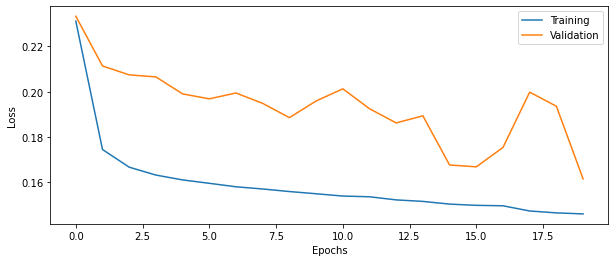

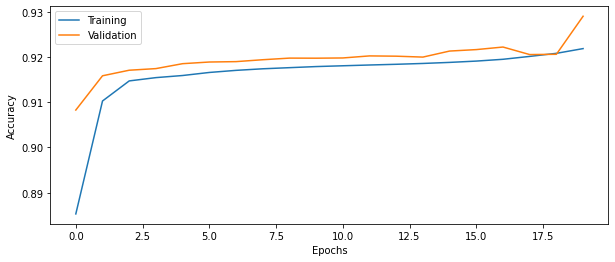

In [31]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [33]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model8 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, optimizer='adam')

history8 = model8.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 14ms/step - loss: 0.2051 - accuracy: 0.8881 - val_loss: 0.2130 - val_accuracy: 0.9161
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1691 - accuracy: 0.9155 - val_loss: 0.2101 - val_accuracy: 0.9185
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1639 - accuracy: 0.9166 - val_loss: 0.2157 - val_accuracy: 0.9189
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1615 - accuracy: 0.9172 - val_loss: 0.2046 - val_accuracy: 0.9196
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1581 - accuracy: 0.9185 - val_loss: 0.1858 - val_accuracy: 0.9220
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1546 - accuracy: 0.9199 - val_loss: 0.1906 - val_accuracy: 0.9218
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.9200 - val_loss: 0.1893 - val_accuracy: 0.9212
Epoch 8/20
54/54 [=

In [34]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1584
Test accuracy: 0.9330


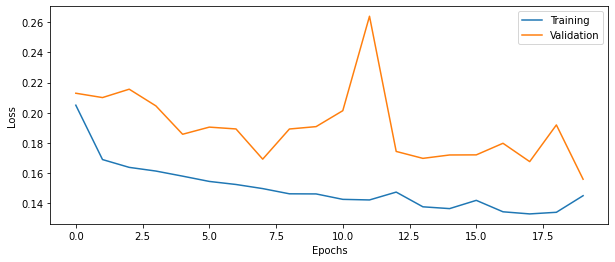

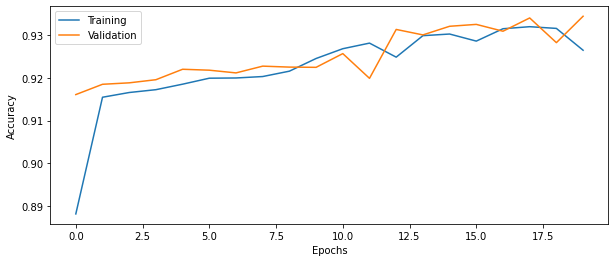

In [35]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

<span style="color:blue"> The validation accuracy after adding dropout is lower (0.9173) compared to the model without dropout(0.9345).</span>

Question 16: How does the test accuracy change when adding dropout?

<span style="color:blue"> The test accuracy after adding dropout is also lower (0.9155) compared to the model without dropout (0.9330). This indicates that while dropout regularization generally can improve the accuracy for validation and test data, in this case it may also reduce the model's ability to generalize to unseen test data, resulting in a decrease in test accuracy.</span>

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [38]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model9 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 18ms/step - loss: 0.4769 - accuracy: 0.7426 - val_loss: 0.2533 - val_accuracy: 0.8818
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2541 - accuracy: 0.8715 - val_loss: 0.2463 - val_accuracy: 0.8820
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2303 - accuracy: 0.8798 - val_loss: 0.2383 - val_accuracy: 0.8934
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2152 - accuracy: 0.8886 - val_loss: 0.2304 - val_accuracy: 0.8991
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2060 - accuracy: 0.8936 - val_loss: 0.2261 - val_accuracy: 0.9010
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1996 - accuracy: 0.8967 - val_loss: 0.2223 - val_accuracy: 0.9040
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1947 - accuracy: 0.8995 - val_loss: 0.2204 - val_accuracy: 0.9056
Epoch 8/20
54/54 [

In [39]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2144
Test accuracy: 0.9155


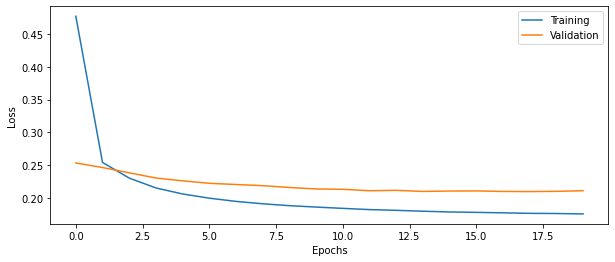

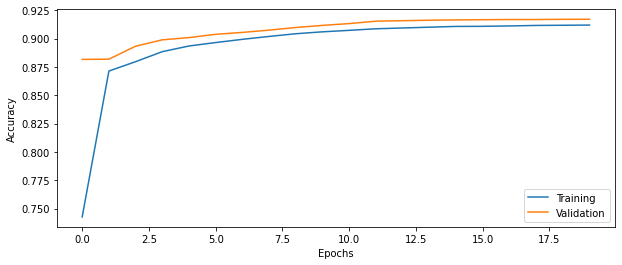

In [40]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

<span style="color:blue"> The highest classification accuracy for the test data are 0.9488, the best configuration are shown as below</span>

In [42]:
import optuna
print(optuna.__version__)

3.6.1


In [46]:
def optuna_objective(trial):
    
    n_layers = trial.suggest_int("n_layers",2,10,step=1) 
    n_nodes = trial.suggest_int("n_nodes",10,50,step= 5)
    act_fun = trial.suggest_categorical("act_fun",['relu','sigmoid'])
    optimizer = trial.suggest_categorical("optimizer",['sgd','adam'])
    learning_rate = trial.suggest_float("learning_rate",0.0001,1,log=True) 
    use_bn = trial.suggest_categorical("use_bn", [True, False])
    use_dropout = trial.suggest_categorical("use_dropout", [True, False])
    epochs = trial.suggest_int("epochs",16,30,step=2)
    batch_size = trial.suggest_categorical("batch_size", [1024, 4096, 16384, 65536])
    dropout_rate = trial.suggest_float("dropout_rate",0.2,0.8,log=False)
    
    model10 = build_DNN(input_shape=input_shape, n_layers=n_layers, n_nodes=n_nodes, act_fun=act_fun, optimizer=optimizer, learning_rate=learning_rate, 
              use_bn=use_bn, use_dropout=use_dropout, use_custom_dropout=False, dropout_rate=dropout_rate)
    model10.fit(Xtrain, Ytrain, class_weight=class_weights, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(Xval,Yval))
    score = model10.evaluate(Xtest, Ytest)
    
    return score[1]

In [47]:
from optuna.samplers import TPESampler
study = optuna.create_study(sampler=TPESampler(), direction='maximize')
study.optimize(optuna_objective, n_trials=30, timeout=1800)

[I 2024-04-21 20:51:20,984] A new study created in memory with name: no-name-a4f15c53-8aa0-45e2-a84a-b5625a251c05


3582/3582 [==============================] - 4s 1ms/step - loss: 0.1894 - accuracy: 0.9170


[I 2024-04-21 20:51:54,122] Trial 0 finished with value: 0.9170047640800476 and parameters: {'n_layers': 3, 'n_nodes': 35, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.5811665747680571, 'use_bn': True, 'use_dropout': False, 'epochs': 28, 'batch_size': 4096, 'dropout_rate': 0.41442629380284957}. Best is trial 0 with value: 0.9170047640800476.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1863 - accuracy: 0.9295


[I 2024-04-21 20:53:05,795] Trial 1 finished with value: 0.9294544458389282 and parameters: {'n_layers': 6, 'n_nodes': 45, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.00022215174068064447, 'use_bn': True, 'use_dropout': False, 'epochs': 30, 'batch_size': 16384, 'dropout_rate': 0.5408958053353714}. Best is trial 1 with value: 0.9294544458389282.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.2593 - accuracy: 0.9255


[I 2024-04-21 20:53:28,063] Trial 2 finished with value: 0.9254586696624756 and parameters: {'n_layers': 2, 'n_nodes': 30, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.13013855137798802, 'use_bn': True, 'use_dropout': True, 'epochs': 20, 'batch_size': 4096, 'dropout_rate': 0.27575934654222617}. Best is trial 1 with value: 0.9294544458389282.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.1523 - accuracy: 0.9352


[I 2024-04-21 20:53:47,779] Trial 3 finished with value: 0.9352387189865112 and parameters: {'n_layers': 2, 'n_nodes': 50, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.010593830603703482, 'use_bn': True, 'use_dropout': False, 'epochs': 16, 'batch_size': 4096, 'dropout_rate': 0.7866199354987566}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.6147 - accuracy: 0.8369


[I 2024-04-21 20:55:07,588] Trial 4 finished with value: 0.8369321227073669 and parameters: {'n_layers': 8, 'n_nodes': 35, 'act_fun': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.00024350374652557904, 'use_bn': True, 'use_dropout': True, 'epochs': 24, 'batch_size': 65536, 'dropout_rate': 0.5041938560365823}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.2023 - accuracy: 0.9163


[I 2024-04-21 20:55:27,670] Trial 5 finished with value: 0.9162893295288086 and parameters: {'n_layers': 2, 'n_nodes': 45, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0015590345646854802, 'use_bn': False, 'use_dropout': True, 'epochs': 26, 'batch_size': 65536, 'dropout_rate': 0.2379753565800125}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.5707 - accuracy: 0.8834


[I 2024-04-21 20:55:55,314] Trial 6 finished with value: 0.8834419250488281 and parameters: {'n_layers': 7, 'n_nodes': 10, 'act_fun': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.00013921703227140622, 'use_bn': True, 'use_dropout': True, 'epochs': 18, 'batch_size': 16384, 'dropout_rate': 0.2927223432505635}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.6539 - accuracy: 0.8873


[I 2024-04-21 20:56:13,238] Trial 7 finished with value: 0.887324333190918 and parameters: {'n_layers': 2, 'n_nodes': 35, 'act_fun': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.0013735197460902253, 'use_bn': False, 'use_dropout': True, 'epochs': 26, 'batch_size': 65536, 'dropout_rate': 0.6122970352637015}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.6958 - accuracy: 0.1578


[I 2024-04-21 20:56:30,878] Trial 8 finished with value: 0.15775468945503235 and parameters: {'n_layers': 8, 'n_nodes': 25, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.14149823266318257, 'use_bn': False, 'use_dropout': False, 'epochs': 16, 'batch_size': 65536, 'dropout_rate': 0.25289966214687076}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.2120 - accuracy: 0.9313


[I 2024-04-21 20:57:19,014] Trial 9 finished with value: 0.9313040375709534 and parameters: {'n_layers': 2, 'n_nodes': 35, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.03038209749700833, 'use_bn': True, 'use_dropout': False, 'epochs': 30, 'batch_size': 1024, 'dropout_rate': 0.7233879760601485}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.1769 - accuracy: 0.9195


[I 2024-04-21 20:57:43,909] Trial 10 finished with value: 0.9195435643196106 and parameters: {'n_layers': 5, 'n_nodes': 50, 'act_fun': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0069201548040068875, 'use_bn': False, 'use_dropout': False, 'epochs': 20, 'batch_size': 4096, 'dropout_rate': 0.7854534509400155}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 5s 2ms/step - loss: 0.1626 - accuracy: 0.9321


[I 2024-04-21 20:58:29,721] Trial 11 finished with value: 0.932124137878418 and parameters: {'n_layers': 4, 'n_nodes': 15, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.02190020805603669, 'use_bn': True, 'use_dropout': False, 'epochs': 22, 'batch_size': 1024, 'dropout_rate': 0.784357840555288}. Best is trial 3 with value: 0.9352387189865112.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1482 - accuracy: 0.9378


[I 2024-04-21 20:59:12,296] Trial 12 finished with value: 0.9378473162651062 and parameters: {'n_layers': 4, 'n_nodes': 10, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.01281563084192679, 'use_bn': True, 'use_dropout': False, 'epochs': 22, 'batch_size': 1024, 'dropout_rate': 0.6950253975422418}. Best is trial 12 with value: 0.9378473162651062.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1669 - accuracy: 0.9347


[I 2024-04-21 20:59:48,733] Trial 13 finished with value: 0.9347152709960938 and parameters: {'n_layers': 4, 'n_nodes': 15, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.006528389890778377, 'use_bn': True, 'use_dropout': False, 'epochs': 16, 'batch_size': 1024, 'dropout_rate': 0.6841306982943864}. Best is trial 12 with value: 0.9378473162651062.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1164 - accuracy: 0.9489


[I 2024-04-21 21:00:35,186] Trial 14 finished with value: 0.9488750100135803 and parameters: {'n_layers': 4, 'n_nodes': 20, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0019533313546367245, 'use_bn': True, 'use_dropout': False, 'epochs': 22, 'batch_size': 1024, 'dropout_rate': 0.6415900075762252}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 6s 2ms/step - loss: 0.1542 - accuracy: 0.9344


[I 2024-04-21 21:02:11,207] Trial 15 finished with value: 0.9344273805618286 and parameters: {'n_layers': 10, 'n_nodes': 20, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.001350688357396935, 'use_bn': True, 'use_dropout': False, 'epochs': 22, 'batch_size': 1024, 'dropout_rate': 0.6159415719808684}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1267 - accuracy: 0.9444


[I 2024-04-21 21:02:59,133] Trial 16 finished with value: 0.9444429874420166 and parameters: {'n_layers': 5, 'n_nodes': 10, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0022606381483942658, 'use_bn': True, 'use_dropout': False, 'epochs': 24, 'batch_size': 1024, 'dropout_rate': 0.6264842580594882}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1444 - accuracy: 0.9370


[I 2024-04-21 21:04:03,629] Trial 17 finished with value: 0.9370185136795044 and parameters: {'n_layers': 6, 'n_nodes': 20, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005872786260079053, 'use_bn': True, 'use_dropout': False, 'epochs': 24, 'batch_size': 1024, 'dropout_rate': 0.4136819947471493}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.1601 - accuracy: 0.9322


[I 2024-04-21 21:04:39,802] Trial 18 finished with value: 0.9322113990783691 and parameters: {'n_layers': 5, 'n_nodes': 20, 'act_fun': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0033604385960269542, 'use_bn': False, 'use_dropout': False, 'epochs': 26, 'batch_size': 1024, 'dropout_rate': 0.5891961201147191}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1604 - accuracy: 0.9350


[I 2024-04-21 21:05:27,440] Trial 19 finished with value: 0.9349682927131653 and parameters: {'n_layers': 5, 'n_nodes': 15, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.000673556593390767, 'use_bn': True, 'use_dropout': False, 'epochs': 20, 'batch_size': 1024, 'dropout_rate': 0.44280737508573154}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 6s 2ms/step - loss: 0.1559 - accuracy: 0.9345


[I 2024-04-21 21:06:06,532] Trial 20 finished with value: 0.9344797134399414 and parameters: {'n_layers': 7, 'n_nodes': 25, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.06145138557052288, 'use_bn': True, 'use_dropout': False, 'epochs': 24, 'batch_size': 16384, 'dropout_rate': 0.6532871944518723}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1499 - accuracy: 0.9350


[I 2024-04-21 21:06:48,420] Trial 21 finished with value: 0.9350467920303345 and parameters: {'n_layers': 4, 'n_nodes': 10, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.003294072906641368, 'use_bn': True, 'use_dropout': False, 'epochs': 22, 'batch_size': 1024, 'dropout_rate': 0.7048215339705395}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 4s 1ms/step - loss: 0.1606 - accuracy: 0.9329


[I 2024-04-21 21:07:23,973] Trial 22 finished with value: 0.9328831434249878 and parameters: {'n_layers': 3, 'n_nodes': 10, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.012872501936342163, 'use_bn': True, 'use_dropout': False, 'epochs': 22, 'batch_size': 1024, 'dropout_rate': 0.5450812001555013}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1343 - accuracy: 0.9411


[I 2024-04-21 21:08:07,023] Trial 23 finished with value: 0.9411451816558838 and parameters: {'n_layers': 4, 'n_nodes': 15, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.0029365710733138474, 'use_bn': True, 'use_dropout': False, 'epochs': 20, 'batch_size': 1024, 'dropout_rate': 0.7255640085442635}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1638 - accuracy: 0.9344


[I 2024-04-21 21:08:40,685] Trial 24 finished with value: 0.9343924522399902 and parameters: {'n_layers': 3, 'n_nodes': 15, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0024939293886881847, 'use_bn': True, 'use_dropout': False, 'epochs': 18, 'batch_size': 1024, 'dropout_rate': 0.7364694692857245}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1633 - accuracy: 0.9339


[I 2024-04-21 21:09:26,100] Trial 25 finished with value: 0.9339039325714111 and parameters: {'n_layers': 5, 'n_nodes': 25, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005191217183941072, 'use_bn': True, 'use_dropout': False, 'epochs': 18, 'batch_size': 1024, 'dropout_rate': 0.6466061486064332}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.6944 - accuracy: 0.1578


[I 2024-04-21 21:10:15,384] Trial 26 finished with value: 0.15775468945503235 and parameters: {'n_layers': 6, 'n_nodes': 20, 'act_fun': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.0042390204026753805, 'use_bn': False, 'use_dropout': True, 'epochs': 20, 'batch_size': 1024, 'dropout_rate': 0.5694224067197743}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1548 - accuracy: 0.9361


[I 2024-04-21 21:10:56,886] Trial 27 finished with value: 0.9360588192939758 and parameters: {'n_layers': 3, 'n_nodes': 15, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0007426904060164885, 'use_bn': True, 'use_dropout': False, 'epochs': 24, 'batch_size': 1024, 'dropout_rate': 0.6534667109935759}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 5s 1ms/step - loss: 0.1683 - accuracy: 0.9297


[I 2024-04-21 21:11:19,307] Trial 28 finished with value: 0.9296900033950806 and parameters: {'n_layers': 4, 'n_nodes': 10, 'act_fun': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.0018782851870094764, 'use_bn': True, 'use_dropout': False, 'epochs': 28, 'batch_size': 16384, 'dropout_rate': 0.7434283618835043}. Best is trial 14 with value: 0.9488750100135803.


3582/3582 [==============================] - 6s 2ms/step - loss: 0.1773 - accuracy: 0.9353


[I 2024-04-21 21:12:08,596] Trial 29 finished with value: 0.9352649450302124 and parameters: {'n_layers': 5, 'n_nodes': 30, 'act_fun': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004800103390028928, 'use_bn': True, 'use_dropout': False, 'epochs': 28, 'batch_size': 4096, 'dropout_rate': 0.3376927761330204}. Best is trial 14 with value: 0.9488750100135803.


In [48]:
print('The highest accuracy for test set is {:.5f}.'.format(study.best_value))

The highest accuracy for test set is 0.94888.


In [49]:
print("The hyperparameters are:")
study.best_params

The hyperparameters are:


{'n_layers': 4,
 'n_nodes': 20,
 'act_fun': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.0019533313546367245,
 'use_bn': True,
 'use_dropout': False,
 'epochs': 22,
 'batch_size': 1024,
 'dropout_rate': 0.6415900075762252}

In [51]:
# Find your best configuration for the DNN
input_shape = (Xtrain.shape[1],)

# Build and train DNN
model10 = build_DNN(input_shape=input_shape, n_layers=study.best_params['n_layers'], n_nodes=study.best_params['n_nodes'], act_fun=study.best_params['act_fun'], optimizer=study.best_params['optimizer'], learning_rate=study.best_params['learning_rate'], 
              use_bn=study.best_params['use_bn'], use_dropout=study.best_params['use_dropout'], use_custom_dropout=False, dropout_rate=study.best_params['dropout_rate'])
history10 = model10.fit(Xtrain, Ytrain, class_weight=class_weights, epochs=study.best_params['epochs'], batch_size=study.best_params['batch_size'], verbose=1, validation_data=(Xval,Yval))


Epoch 1/22
523/523 [==============================] - 6s 6ms/step - loss: 0.2031 - accuracy: 0.9059 - val_loss: 0.2025 - val_accuracy: 0.9171
Epoch 2/22
523/523 [==============================] - 2s 4ms/step - loss: 0.1623 - accuracy: 0.9170 - val_loss: 0.1940 - val_accuracy: 0.9195
Epoch 3/22
523/523 [==============================] - 2s 4ms/step - loss: 0.1532 - accuracy: 0.9197 - val_loss: 0.1739 - val_accuracy: 0.9261
Epoch 4/22
523/523 [==============================] - 2s 4ms/step - loss: 0.1431 - accuracy: 0.9264 - val_loss: 0.1826 - val_accuracy: 0.9297
Epoch 5/22
523/523 [==============================] - 2s 4ms/step - loss: 0.1366 - accuracy: 0.9299 - val_loss: 0.1753 - val_accuracy: 0.9285
Epoch 6/22
523/523 [==============================] - 2s 4ms/step - loss: 0.1326 - accuracy: 0.9317 - val_loss: 0.1596 - val_accuracy: 0.9326
Epoch 7/22
523/523 [==============================] - 2s 4ms/step - loss: 0.1296 - accuracy: 0.9331 - val_loss: 0.1655 - val_accuracy: 0.9363
Epoch 

In [52]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1560
Test accuracy: 0.9368


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

<span style="color:blue"> The mean and standard deviation of the test accuracy are 0.93127 and 0.000117 respectively as below show.</span>

In [53]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [57]:
# Your best training parameters
input_shape = (Xtrain.shape[1],)

# Build and train model
model11 = build_DNN(input_shape=input_shape, n_layers=study.best_params['n_layers'], n_nodes=study.best_params['n_nodes'], act_fun=study.best_params['act_fun'], optimizer=study.best_params['optimizer'], learning_rate=study.best_params['learning_rate'], 
              use_bn=study.best_params['use_bn'], use_custom_dropout=True)

history11 = model11.fit(Xtrain, Ytrain, class_weight=class_weights, epochs=study.best_params['epochs'], batch_size=study.best_params['batch_size'], verbose=1, validation_data=(Xval,Yval))


Epoch 1/22
523/523 [==============================] - 7s 6ms/step - loss: 0.3078 - accuracy: 0.8874 - val_loss: 0.2668 - val_accuracy: 0.9137
Epoch 2/22
523/523 [==============================] - 2s 5ms/step - loss: 0.2059 - accuracy: 0.9144 - val_loss: 0.2219 - val_accuracy: 0.9166
Epoch 3/22
523/523 [==============================] - 2s 5ms/step - loss: 0.1866 - accuracy: 0.9157 - val_loss: 0.2200 - val_accuracy: 0.9175
Epoch 4/22
523/523 [==============================] - 2s 5ms/step - loss: 0.1770 - accuracy: 0.9159 - val_loss: 0.2181 - val_accuracy: 0.9179
Epoch 5/22
523/523 [==============================] - 3s 5ms/step - loss: 0.1730 - accuracy: 0.9162 - val_loss: 0.2141 - val_accuracy: 0.9183
Epoch 6/22
523/523 [==============================] - 3s 5ms/step - loss: 0.1709 - accuracy: 0.9163 - val_loss: 0.1950 - val_accuracy: 0.9189
Epoch 7/22
523/523 [==============================] - 2s 5ms/step - loss: 0.1684 - accuracy: 0.9167 - val_loss: 0.2012 - val_accuracy: 0.9168
Epoch 

In [59]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
for i in range(5):
    score = model11.evaluate(Xtest, Ytest)                       
    print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.1786 - accuracy: 0.9313
Test accuracy: 0.9313
3582/3582 [==============================] - 6s 2ms/step - loss: 0.1782 - accuracy: 0.9314
Test accuracy: 0.9314
3582/3582 [==============================] - 6s 2ms/step - loss: 0.1786 - accuracy: 0.9313
Test accuracy: 0.9313
3582/3582 [==============================] - 5s 1ms/step - loss: 0.1782 - accuracy: 0.9314
Test accuracy: 0.9314
3582/3582 [==============================] - 5s 1ms/step - loss: 0.1786 - accuracy: 0.9313
Test accuracy: 0.9313


In [60]:
# Run the testing 100 times, and save the accuracies in an array
# Placeholder for accuracies
accuracies = []

# Run the testing 100 times
for i in range(100):
    # Evaluate model on test data
    score = model11.evaluate(Xtest, Ytest, verbose=0)
    accuracies.append(score[1])
    
# Calculate and print mean and std of accuracies
print('Mean accuracy: ', np.mean(accuracies))
print('Standard deviation: ', np.std(accuracies))


Mean accuracy:  0.9312707126140595
Standard deviation:  0.00011739754091522747


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

<span style="color:blue"> The mean and standard deviation of the test accuracy are 0.9366 and 0.004067 respectively as below shown.</span>

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

<span style="color:blue"> The main advantage of dropout compared to CV for estimating test uncertainty is that dropout is much less computationally expensive. Dropout can be easily parallelized because each dropout mask is independent. On the other hand, CV requires training the model from scratch for each fold, which can be computationally expensive for large models and datasets.</span>

In [61]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Placeholder for accuracies
cv_accuracies = []

input_shape = (Xtrain.shape[1],)

# Loop over cross validation folds
for train, test in kfold.split(X, Y):
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight('balanced', np.unique(Y[train]), Y[train])
    class_weights = dict(enumerate(class_weights))

    # Rebuild the DNN model, to not continue training on the previously trained model
    model = build_DNN(input_shape=input_shape, n_layers=study.best_params['n_layers'], n_nodes=study.best_params['n_nodes'], act_fun=study.best_params['act_fun'], optimizer=study.best_params['optimizer'], learning_rate=study.best_params['learning_rate'], 
              use_bn=study.best_params['use_bn'])

    # Fit the model with training set and class weights for this fold
    model.fit(X[train], Y[train], batch_size=study.best_params['batch_size'], epochs=study.best_params['epochs'], verbose=0, class_weight=class_weights)

    # Evaluate the model using the test set for this fold
    score = model.evaluate(X[test], Y[test], verbose=0)

    # Save the test accuracy in an array
    cv_accuracies.append(score[1])

# Calculate and print mean and std of accuracies
print('Mean accuracy: ', np.mean(cv_accuracies))
print('Standard deviation: ', np.std(cv_accuracies))


Mean accuracy:  0.9366134524345398
Standard deviation:  0.004067192034317146


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

<span style="color:blue">1) Change the activation function of the output layer to linear, i.e., no activation function. This is because the output for regression is a continuous value, while the output for classification is a discrete class label.</span>

<span style="color:blue">2) Change the loss function to a regression loss such as Mean Squared Error (MSE) or Mean Absolute Error (MAE), instead of a classification loss such as cross-entropy.</span>

## Report

Send in this jupyter notebook, with answers to all questions.